# Implementing a Neural Network from Scrath - Experimenting

This experiment is based on [this blog post](https://dennybritz.com/posts/wildml/implementing-a-neural-network-from-scratch/) and is a part of a report for a ML for NLP course at the University of Trento, CIMeC.

Experimenting with it, I managed to:
- implement a slightly bigger moon-shaped dataset;
- divide it into train and test splits;
- change the gradient descent for a minibatch gradient descent with `batch_size = 32`;
- implement an annealing schedule for the gradient descent learning rate, decreasing it each 2000 passages;
- experiment with other activation function;
- test each model's accuracy;
- plot all the results.

Moreover, most of the function have been slighly modified to integrate more modulability (e.g., using the specified activation function, loading the the training dataset...)


In [16]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Split and test model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Print results
import pandas as pd
from tabulate import tabulate

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# Function to split data into train and test sets
def train_test_split_data(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, random_state=0)

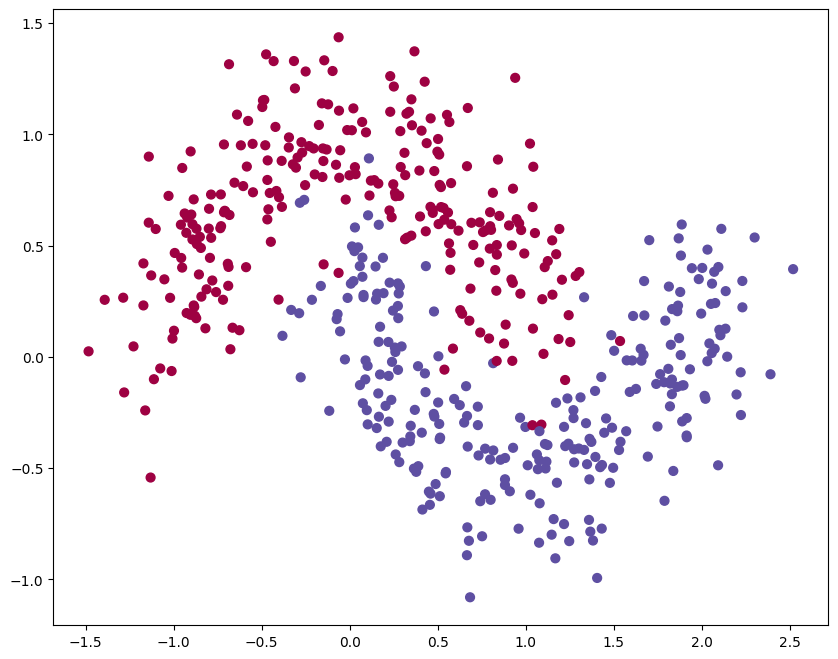

In [3]:
# Generate a dataset and plot it
np.random.seed(0)
X_orig, y_orig = sklearn.datasets.make_moons(512, noise=0.20)
plt.scatter(X_orig[:,0], X_orig[:,1], s=40, c=y_orig, cmap=plt.cm.Spectral)

In [4]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split_data(X=X_orig, y=y_orig)


In [5]:
# Define variables
num_examples = len(X_train) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength


In [6]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X_train, y_train)

LogisticRegressionCV()

In [7]:
def plot_decision_boundary(pred_func, X, y, ax=None):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    if ax is None:
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    else:
        ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


Text(0.5, 1.0, 'Logistic Regression')

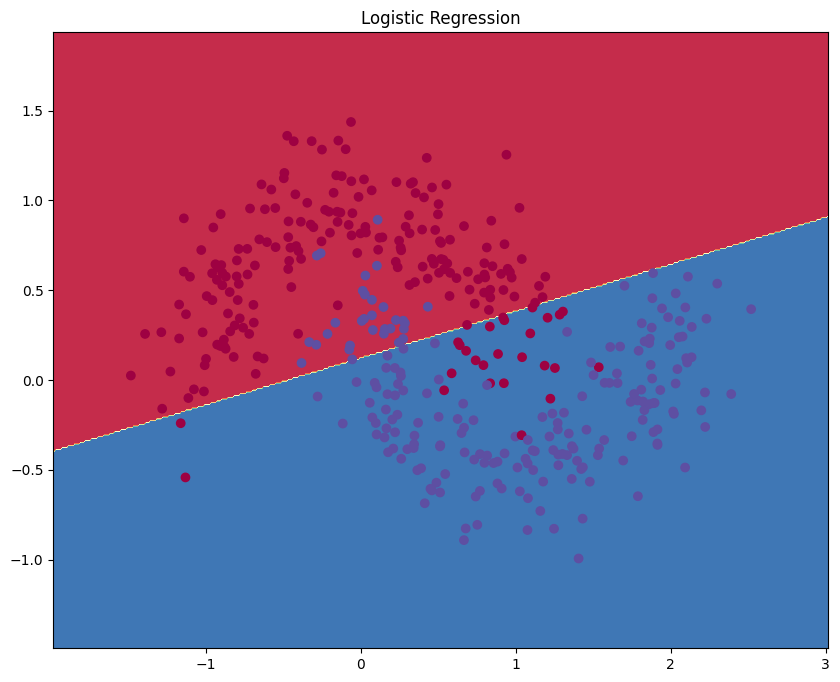

In [8]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x), X=X_train, y=y_train)
plt.title("Logistic Regression")

In [9]:
""" Class to access Activation Functions """
class ActFun:
    def __init__(self):
        # Constructor method (currently does nothing)
        pass
    
    def tanh(self, x):
        # Computes the hyperbolic tangent of x
        return np.tanh(x)
    
    def tanh_d(self, x):
        # Computes the derivative of the hyperbolic tangent function
        return 1.0 - np.tanh(x)**2
    
    def sigmoid(self, x):
        # Computes the sigmoid function of x
        return 1.0 / (1.0 + np.exp(-x))
    
    def sigmoid_d(self, x):
        # Computes the derivative of the sigmoid function
        sigmoid_x = self.sigmoid(x)  
        return sigmoid_x * (1 - sigmoid_x)  
    
    def relu(self, x):
        # Computes the ReLU (Rectified Linear Unit) of x
        return np.maximum(0, x)
    
    def relu_d(self, x):
        # Computes the derivative of the ReLU function
        # Read as "if x > 0 then 1, else 0"
        return np.where(x > 0, 1.0, 0.0)
    
    def swish(self, x):
        # Computes the Swish activation function of x with beta set to 1 (so skipped)
        return x * self.sigmoid(x)

    def swish_d(self, x):
        # Computes the derivative of the Swish function
        swish_x = self.swish(x)
        return swish_x + (1 - swish_x) * self.sigmoid(x)

# Instantiate an object of the ActFun class
a = ActFun()


In [10]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model, X, y, act_fun):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = act_fun(z1)  # use the specified activation function
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)

    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss


In [11]:
# Helper function to predict an output (0 or 1)
def predict(model, x, act_fun):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = act_fun(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)


In [12]:

def build_model(X, y, nn_hdim, act_fun, d_fun, num_passes=20000, print_loss=False, batch_size=32, decay_rate=0.8, decay_step=2000):
    """
    This function learns parameters for the neural network and returns the model.

    X, y: The data to use
    nn_hdim: Number of nodes in the hidden layer
    act_fun, d_fun: Activation function and relative derivative
    num_passes: Number of passes through the training data for gradient descent
    print_loss: If True, print the loss every 1000 iterations
    batch_size: Size of the batch to use for Minibatch Gradient Descent
    decay_rate: The multiplier to decrease the learning rate
    decay_step: How often the learning rate has to drop
    """

    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}

    # Load the variable learning rate into another variable
    var_epsilon = epsilon
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Apply step decay with the set parameters
        if i % decay_step == 0 and i != 0:
            var_epsilon *= decay_rate
            #print(var_epsilon)

        # Shuffle the data at the start of each epoch
        perm = np.random.permutation(num_examples)
        X_shuffled = X[perm]
        y_shuffled = y[perm]

        # Minibatch Gradient Descent implementation
        for j in range(0, num_examples, batch_size):  # Access the data
            X_batch = X_shuffled[j:j+batch_size]  # Extract a subset of the shuffled input
            y_batch = y_shuffled[j:j+batch_size]  # Idem

            # Forward propagation
            z1 = X_batch.dot(W1) + b1
            a1 = act_fun(z1)  # act_fun ensures we use the specified activation function
            z2 = a1.dot(W2) + b2
            exp_scores = np.exp(z2)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            # Backpropagation
            delta3 = probs
            delta3[range(len(y_batch)), y_batch] -= 1  # For each training example in the mini-batch, subtract 1 from the probability of the true class. 
            dW2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            delta2 = delta3.dot(W2.T) * d_fun(z1)  #d_fun esnrues we use the speicified derivative
            dW1 = np.dot(X_batch.T, delta2)  # Compute the gradient of the loss with respect to the weights of the first layer
            db1 = np.sum(delta2, axis=0)

            # Add regularization terms (b1 and b2 don't have regularization terms)
            dW2 += reg_lambda * W2
            dW1 += reg_lambda * W1
        
            # Gradient descent parameter update
            W1 += -var_epsilon * dW1
            b1 += -var_epsilon * db1
            W2 += -var_epsilon * dW2
            b2 += -var_epsilon * db2
            
            # Assign new parameters to the model
            model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model, X=X, y=y, act_fun=act_fun)))
        
        # Store the loss at the final step
        if i == num_passes-1:
          final_loss = calculate_loss(model, X=X, y=y, act_fun=act_fun)
          if print_loss:
            print(f'Final loss: {final_loss:.3f}')

    
    return model, final_loss

In [13]:
# Helper function to evaluate the model using sklearn
def evaluate_model(model, X_test, y_test, act_fun):
    y_pred = predict(model, X_test, act_fun)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

## In practice

Here we can see how all the above created functions perform together.  
We'll first present a model more verbose, and then go to plot a whole bunch of models with different hyperparameters and see how they perform

Loss after iteration 0: 0.393922


Loss after iteration 1000: 0.268442
Loss after iteration 2000: 0.295290
Loss after iteration 3000: 0.266065
Loss after iteration 4000: 0.279312
Loss after iteration 5000: 0.261955
Loss after iteration 6000: 0.264306
Loss after iteration 7000: 0.264427
Loss after iteration 8000: 0.259979
Loss after iteration 9000: 0.275447
Loss after iteration 10000: 0.258600
Loss after iteration 11000: 0.258815
Loss after iteration 12000: 0.261143
Loss after iteration 13000: 0.264939
Loss after iteration 14000: 0.256599
Loss after iteration 15000: 0.265718
Loss after iteration 16000: 0.257516
Loss after iteration 17000: 0.258733
Loss after iteration 18000: 0.258917
Loss after iteration 19000: 0.256261
Final loss: 0.258


Text(0.5, 1.0, 'Hidden Layer size 3, relu')

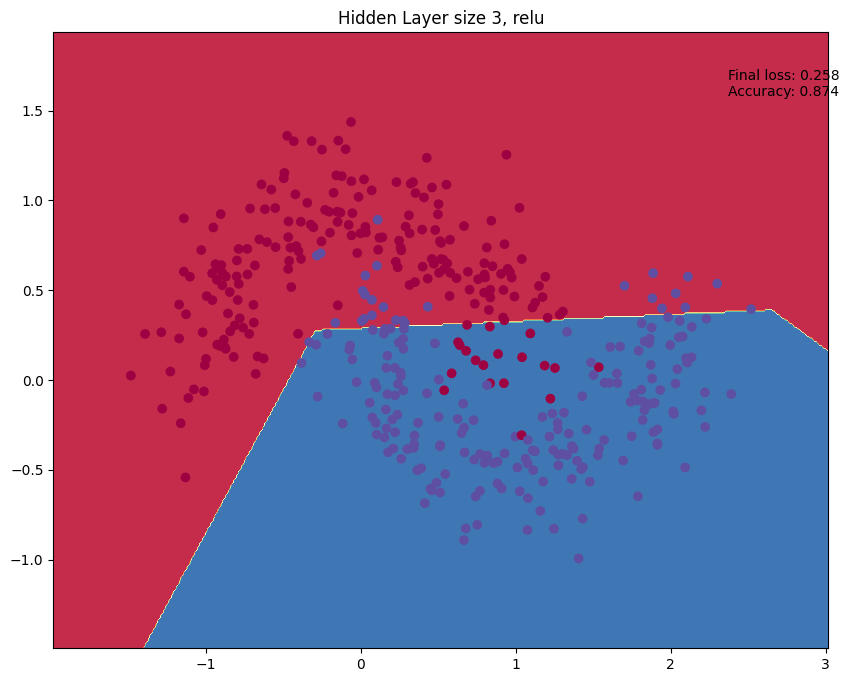

In [14]:
# Build a model with a 3-dimensional hidden layer
act_fun = a.relu
derivative = a.relu_d
hdim = 3

model, final_loss = build_model(X=X_train, y=y_train, nn_hdim=hdim, act_fun=act_fun, d_fun=derivative, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x, act_fun=act_fun), X=X_train, y=y_train)
accuracy = evaluate_model(model, X_test, y_test, act_fun)
plt.figtext(.8, .8, f"Final loss: {final_loss:.3f}\nAccuracy: {accuracy:.3f}")
plt.title(f'Hidden Layer size {hdim}, {str(act_fun.__qualname__).split(".", 1)[1]}')

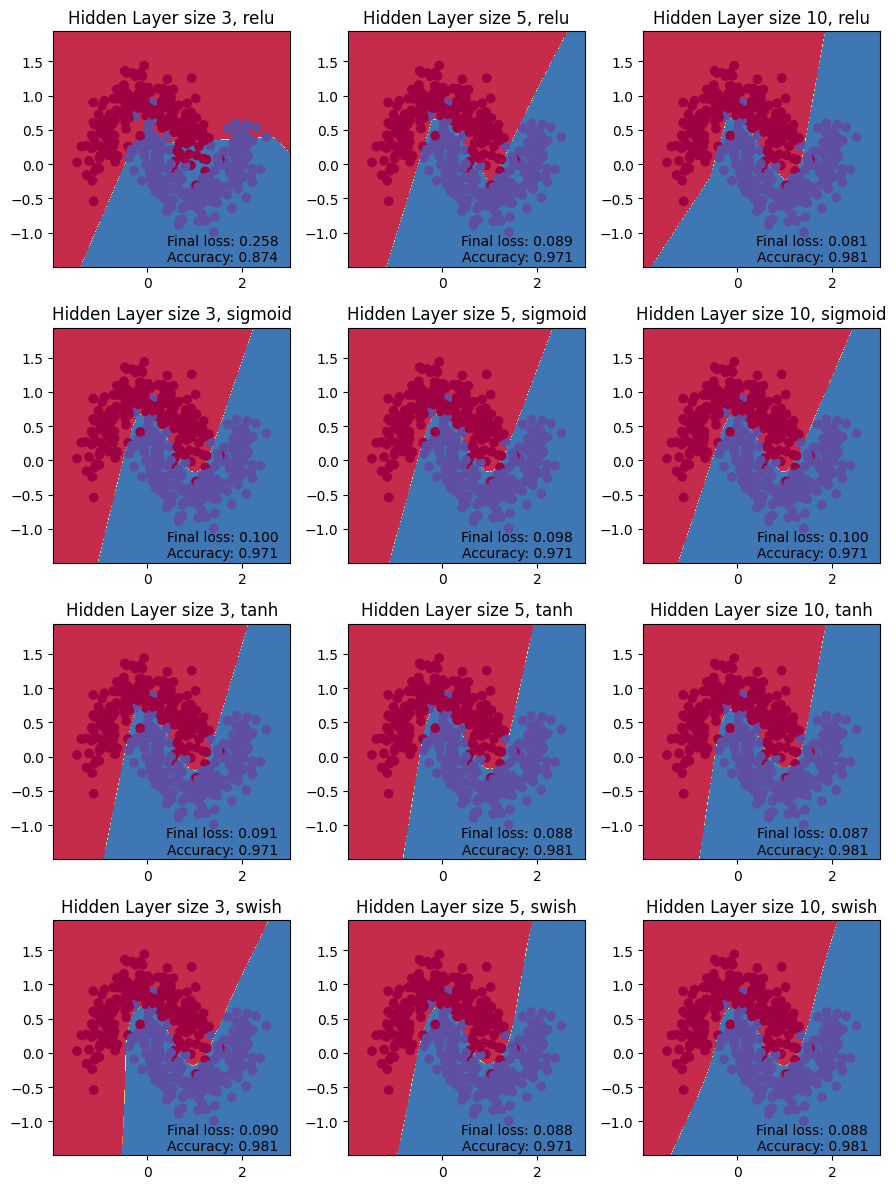

In [17]:
""" Plot multiple models and their accuracy on the test"""
hidden_layer_dimensions = [3, 5, 10]
activations = [a.relu,      a.sigmoid,      a.tanh,     a.swish]
derivatives = [a.relu_d,    a.sigmoid_d,    a.tanh_d,   a.swish_d]

fig, axes = plt.subplots(nrows=len(activations),
                         ncols=len(hidden_layer_dimensions),
                         figsize=((len(hidden_layer_dimensions)*3),
                                  (len(activations)*3)))

# Collect data for the table
results = []

# Plot subplots. For each activation function and derivative...
for row, (aa, dd) in enumerate(zip(activations, derivatives)):
    # For each hidden layer...
    for col, nn_hdim in enumerate(hidden_layer_dimensions):
        act_fun_name = str(aa.__qualname__).split(".", 1)[1]  # Retrieve name of the function
        ax = axes[row, col]
        ax.set_title(f'Hidden Layer size {nn_hdim}, {act_fun_name}')
        model, final_loss = build_model(X=X_train, y=y_train, nn_hdim=nn_hdim, act_fun=aa, d_fun=dd)
        accuracy = evaluate_model(model, X_test, y_test, aa)
        plot_decision_boundary(lambda x: predict(model, x, act_fun=aa), X=X_train, y=y_train, ax=ax)
        ax.text(0.95, 0.01, f"Final loss: {final_loss:.3f}\nAccuracy: {accuracy:.3f}", verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
        results.append([nn_hdim, act_fun_name, final_loss, accuracy])
plt.tight_layout()
plt.show()


In [24]:
# Create and display the results table
results_df = pd.DataFrame(results, columns=['Hidden Layer Size', 'Activation Function', 'Final Loss', 'Accuracy'])
print(tabulate(results_df, headers=results_df.columns))

      Hidden Layer Size  Activation Function      Final Loss    Accuracy
--  -------------------  ---------------------  ------------  ----------
 0                    3  relu                      0.257964     0.873786
 1                    5  relu                      0.0889436    0.970874
 2                   10  relu                      0.0809903    0.980583
 3                    3  sigmoid                   0.0996274    0.970874
 4                    5  sigmoid                   0.0984919    0.970874
 5                   10  sigmoid                   0.100164     0.970874
 6                    3  tanh                      0.0905246    0.970874
 7                    5  tanh                      0.0880526    0.980583
 8                   10  tanh                      0.0867773    0.980583
 9                    3  swish                     0.0900949    0.980583
10                    5  swish                     0.0884798    0.970874
11                   10  swish                     